In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import all basic modules

import numpy as np 
import transformers
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_json('drive/MyDrive/ColabNotebooks/News_Category_Dataset_v3.json',lines=True)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


### PREPROCESSING THE DATA

In [ ]:
df.describe()

<ipython-input-4-ea8415b8a3ee>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,link,headline,category,short_description,authors,date
count,209527,209527,209527,209527,209527,209527
unique,209486,207996,42,187022,29169,3890
top,https://www.huffingtonpost.comhttps://www.wash...,Sunday Roundup,POLITICS,,,2014-03-25 00:00:00
freq,2,90,35602,19712,37418,100
first,NaN,NaN,NaN,NaN,NaN,2012-01-28 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2022-09-23 00:00:00


In [ ]:
df = df[df.category != 'U.S. NEWS']

In [ ]:
df['category'].value_counts()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION          1014
Name: category, 

In [ ]:
min(df['category'].value_counts())

1014

Every category has more than 1000 examples

In [ ]:
# store the total number of categories

num_labels = len(df['category'].unique())
num_labels

41

In [ ]:
#import bert model and tokenizer

bert = transformers.AutoModel.from_pretrained('bert-base-uncased')
tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We use the headline and short_description columns as our features. 
To get a better understanding of the sequence lengths we concatenate out feature strings and plot their lengths 

<AxesSubplot:>

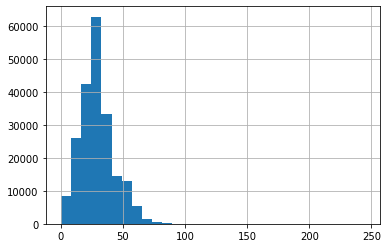

In [ ]:
seq = df['headline'] + ' ' + df['short_description']
seq_len = pd.Series([len(x.split()) for x in seq])
seq_len.hist(bins=30)

We choose 50 as our max seq length from the plot

In [ ]:
max_seq_len = 50

In [ ]:
#split dataset 4:1 for training and testing
 
train_x, test_x, train_y, test_y = train_test_split(df[['headline','short_description']], df['category'], test_size=0.2, stratify=df['category'])

In [ ]:
#encoding training and testing labels 

le = LabelEncoder()
le.fit(df['category'])
train_y = le.transform(train_y)
test_y = le.transform(test_y)

In [ ]:
#tokenize train batch and test batch

test_tokens = tokenizer.batch_encode_plus(
    list(test_x.values),
    max_length = max_seq_len,
    pad_to_max_length = True,
    truncation=True,
    return_token_type_ids = False,
    return_tensors = 'pt'
)
train_tokens = tokenizer.batch_encode_plus(
    list(train_x.values),
    max_length = max_seq_len,
    pad_to_max_length = True,
    truncation=True,
    return_token_type_ids = False,
    return_tensors = 'pt'
)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### FINE TUNING

In [ ]:
#use gpu for training if available

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#using one hot encoding for multiple classes

train_labels = torch.nn.functional.one_hot(torch.tensor(train_y,device=device).to(torch.int64),num_classes=num_labels)
test_labels = torch.nn.functional.one_hot(torch.tensor(test_y,device=device).to(torch.int64),num_classes=num_labels)

<ipython-input-17-1de3c01bd4f1>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_xticklabels(df['category'].unique(), rotation=90)


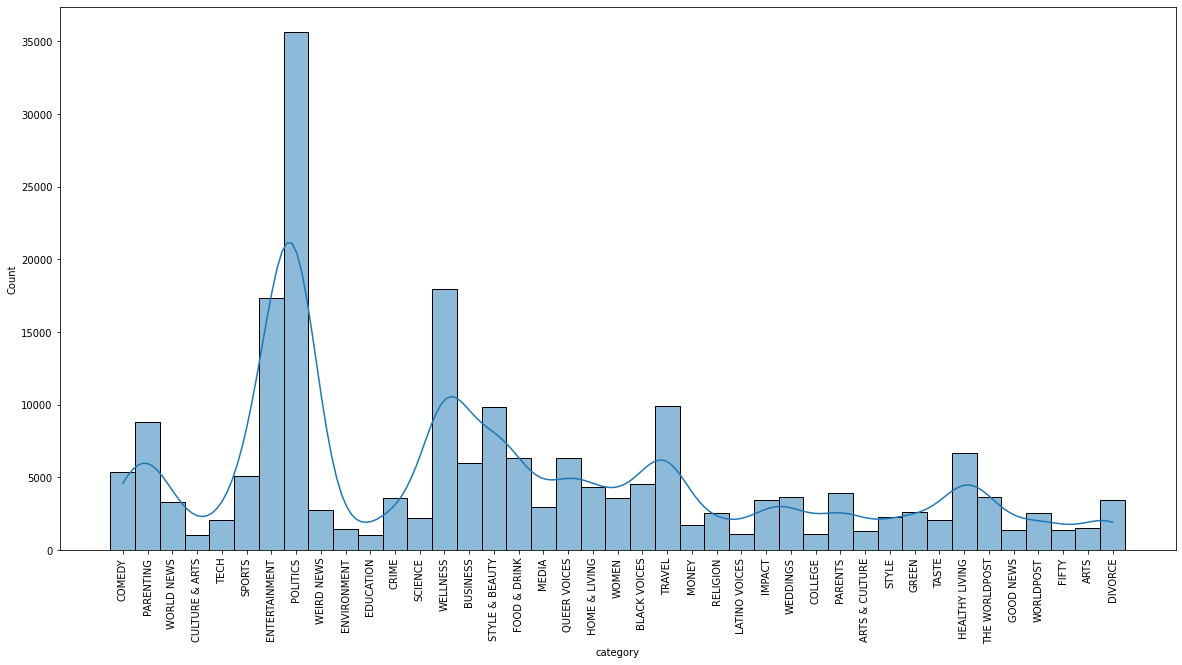

In [ ]:
plt.figure(figsize=(20,10))
bar_plot = sns.histplot(df['category'], kde=True)
bar_plot.set_xticklabels(df['category'].unique(), rotation=90)
plt.show()

As our label distribution is a bit skewed its best to use class weights in out loss function 

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=np.unique(train_y), y=train_y))
class_weights

tensor([3.3649, 3.7922, 1.1079, 0.8472, 4.4388, 0.9402, 1.4251, 4.7281, 1.4817,
        5.0080, 0.2924, 3.5164, 3.6231, 0.8008, 3.6328, 1.9359, 0.7584, 1.1752,
        1.4573, 4.4928, 1.7246, 2.8907, 0.5775, 1.2836, 0.1426, 0.7998, 1.9697,
        2.3011, 0.9999, 2.2526, 0.5173, 2.4219, 2.4132, 1.3857, 0.5128, 1.3900,
        1.8278, 0.2829, 1.4211, 1.5390, 1.9687], dtype=torch.float64)

In [ ]:
#Preparing text sequences and attention masks 

train_seq = train_tokens['input_ids'].to(device)
train_atten_mask = train_tokens['attention_mask'].to(device)
test_seq = test_tokens['input_ids'].to(device)
test_atten_mask = test_tokens['attention_mask'].to(device)
train_seq.shape, train_atten_mask.shape, train_labels.shape

(torch.Size([166520, 50]), torch.Size([166520, 50]), torch.Size([166520, 41]))

In [ ]:
#making tensor datasets

train_dataset = TensorDataset(train_seq, train_atten_mask, train_labels)
test_dataset = TensorDataset(test_seq, test_atten_mask, test_labels)

In [ ]:
#initializing train and test dataloaders

batch_size = 32

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [ ]:
#freeze params
for params in bert.parameters():
    params.requires_grad = False

We define the architecture of our model here.

Alongside the pretrained BERT model we will have two fully connected layers with a dropout layer in between and we will use RELU as the activation function.

[seq, attn_mask] -> BERT -> fcLinear(768,512) -> RELU -> DropoutLayer -> fcLinear(512, num_labels) -> vector of size (num_labels) with probabilities for predicted class label

In [ ]:
class BERT(nn.Module):
    def __init__(self, bert, num_labels):
        super().__init__()
        self.bert = bert
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,num_labels)
        self.dropout = nn.Dropout(0.1)
    def forward(self, seq, mask):
        outputs = self.bert(seq, attention_mask=mask)
        lhs = outputs[0][:, 0, :]
        x = self.fc1(lhs)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
#load model in gpu if available

model = BERT(bert, num_labels).to(device)

In [ ]:
#We will use AdamW as out optimizer and CrossEntropy loss with our class weights as out loss function

optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

In [ ]:
def train_step(epoch_no):
  model.train()
  running_loss = 0.0
  total_loss = 0.0
  print(f"Epoch {epoch_no}\n"+"-"*25)
  for step, batch in enumerate(train_dataloader):
      seq, mask, label = batch 
      model.zero_grad()
      preds = model(seq, mask)
      loss = criterion(preds, label.to(torch.float)) 
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      total_loss += loss.item()
      if step % 500 == 499:
        print(f'[{epoch_no}, {step:5d}] loss: {running_loss / 500:.3f}')
        running_loss = 0.0
  return total_loss/len(train_dataloader)


In [ ]:
def eval_step():
  model.eval()
  total_loss = 0.0
  correct_pred = 0
  with torch.no_grad():
    for batch in test_dataloader:
      seq, mask, label = batch
      preds = model(seq, mask)
      loss = criterion(preds, label.to(torch.float))
      total_loss += loss.item()
      correct_pred += torch.sum(torch.argmax(model(seq, mask), dim=-1) == torch.argmax(label,dim=-1)).item()
  return total_loss/len(test_dataloader), correct_pred/len(test_dataset)*100


In [ ]:
#training the model

epochs = 6
eval_metrics = {
    "train_losses" : [],
    "test_losses" : []
}

for epoch in range(epochs):
  train_loss = train_step(epoch)
  print(f'Average train loss = {train_loss:.4f}')
  test_loss, acc = eval_step()
  print(f'Average test loss = {test_loss} accuracy = {acc:.2f}')
  eval_metrics['train_losses'].append(train_loss)
  eval_metrics['test_losses'].append(test_loss)

print(f'------------Training finished for {epoch} epochs--------------')

Epoch 0
-------------------------
[0,   499] loss: 2.673
[0,   999] loss: 2.096
[0,  1499] loss: 2.031
[0,  1999] loss: 1.963
[0,  2499] loss: 1.906
[0,  2999] loss: 1.870
[0,  3499] loss: 1.893
[0,  3999] loss: 1.872
[0,  4499] loss: 1.881
[0,  4999] loss: 1.825
Average train loss = 1.9953
Average test loss = 1.7182222450165618 accuracy = 48.98
Epoch 1
-------------------------
[1,   499] loss: 1.800
[1,   999] loss: 1.767
[1,  1499] loss: 1.815
[1,  1999] loss: 1.821
[1,  2499] loss: 1.804
[1,  2999] loss: 1.792
[1,  3499] loss: 1.780
[1,  3999] loss: 1.764
[1,  4499] loss: 1.744
[1,  4999] loss: 1.756
Average train loss = 1.7854
Average test loss = 1.6432331966527876 accuracy = 50.92
Epoch 2
-------------------------
[2,   499] loss: 1.691
[2,   999] loss: 1.716
[2,  1499] loss: 1.743
[2,  1999] loss: 1.747
[2,  2499] loss: 1.744
[2,  2999] loss: 1.755
[2,  3499] loss: 1.725
[2,  3999] loss: 1.731
[2,  4499] loss: 1.745
[2,  4999] loss: 1.749
Average train loss = 1.7349
Average test

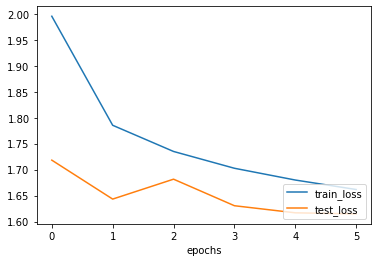

In [ ]:
#plot train and test loss 

plt.plot(eval_metrics['train_losses'], label='train_loss')
plt.plot(eval_metrics['test_losses'], label='test_loss')
plt.xlabel('epochs')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#calculating metrics for classification report

ground_truth, preds = [], []
with torch.no_grad():
  for batch in test_dataloader:
    test_seq, test_mask, test_labels = batch
    predictions = torch.argmax(model(test_seq, test_mask), dim=-1)
    preds += predictions.cpu().tolist()
    ground_truth += torch.argmax(test_labels, dim=-1).cpu().tolist()

In [ ]:
print(classification_report(ground_truth, preds, target_names=df['category'].unique()))

                precision    recall  f1-score   support

        COMEDY       0.24      0.43      0.30       302
     PARENTING       0.17      0.58      0.26       268
    WORLD NEWS       0.40      0.35      0.37       917
CULTURE & ARTS       0.49      0.42      0.45      1198
          TECH       0.34      0.49      0.40       229
        SPORTS       0.30      0.45      0.36      1080
 ENTERTAINMENT       0.46      0.68      0.55       712
      POLITICS       0.18      0.68      0.28       215
    WEIRD NEWS       0.57      0.68      0.62       685
   ENVIRONMENT       0.22      0.53      0.31       203
     EDUCATION       0.81      0.31      0.45      3472
         CRIME       0.30      0.57      0.40       289
       SCIENCE       0.13      0.42      0.19       280
      WELLNESS       0.57      0.78      0.66      1268
      BUSINESS       0.26      0.38      0.31       280
STYLE & BEAUTY       0.36      0.42      0.39       524
  FOOD & DRINK       0.50      0.28      0.36  

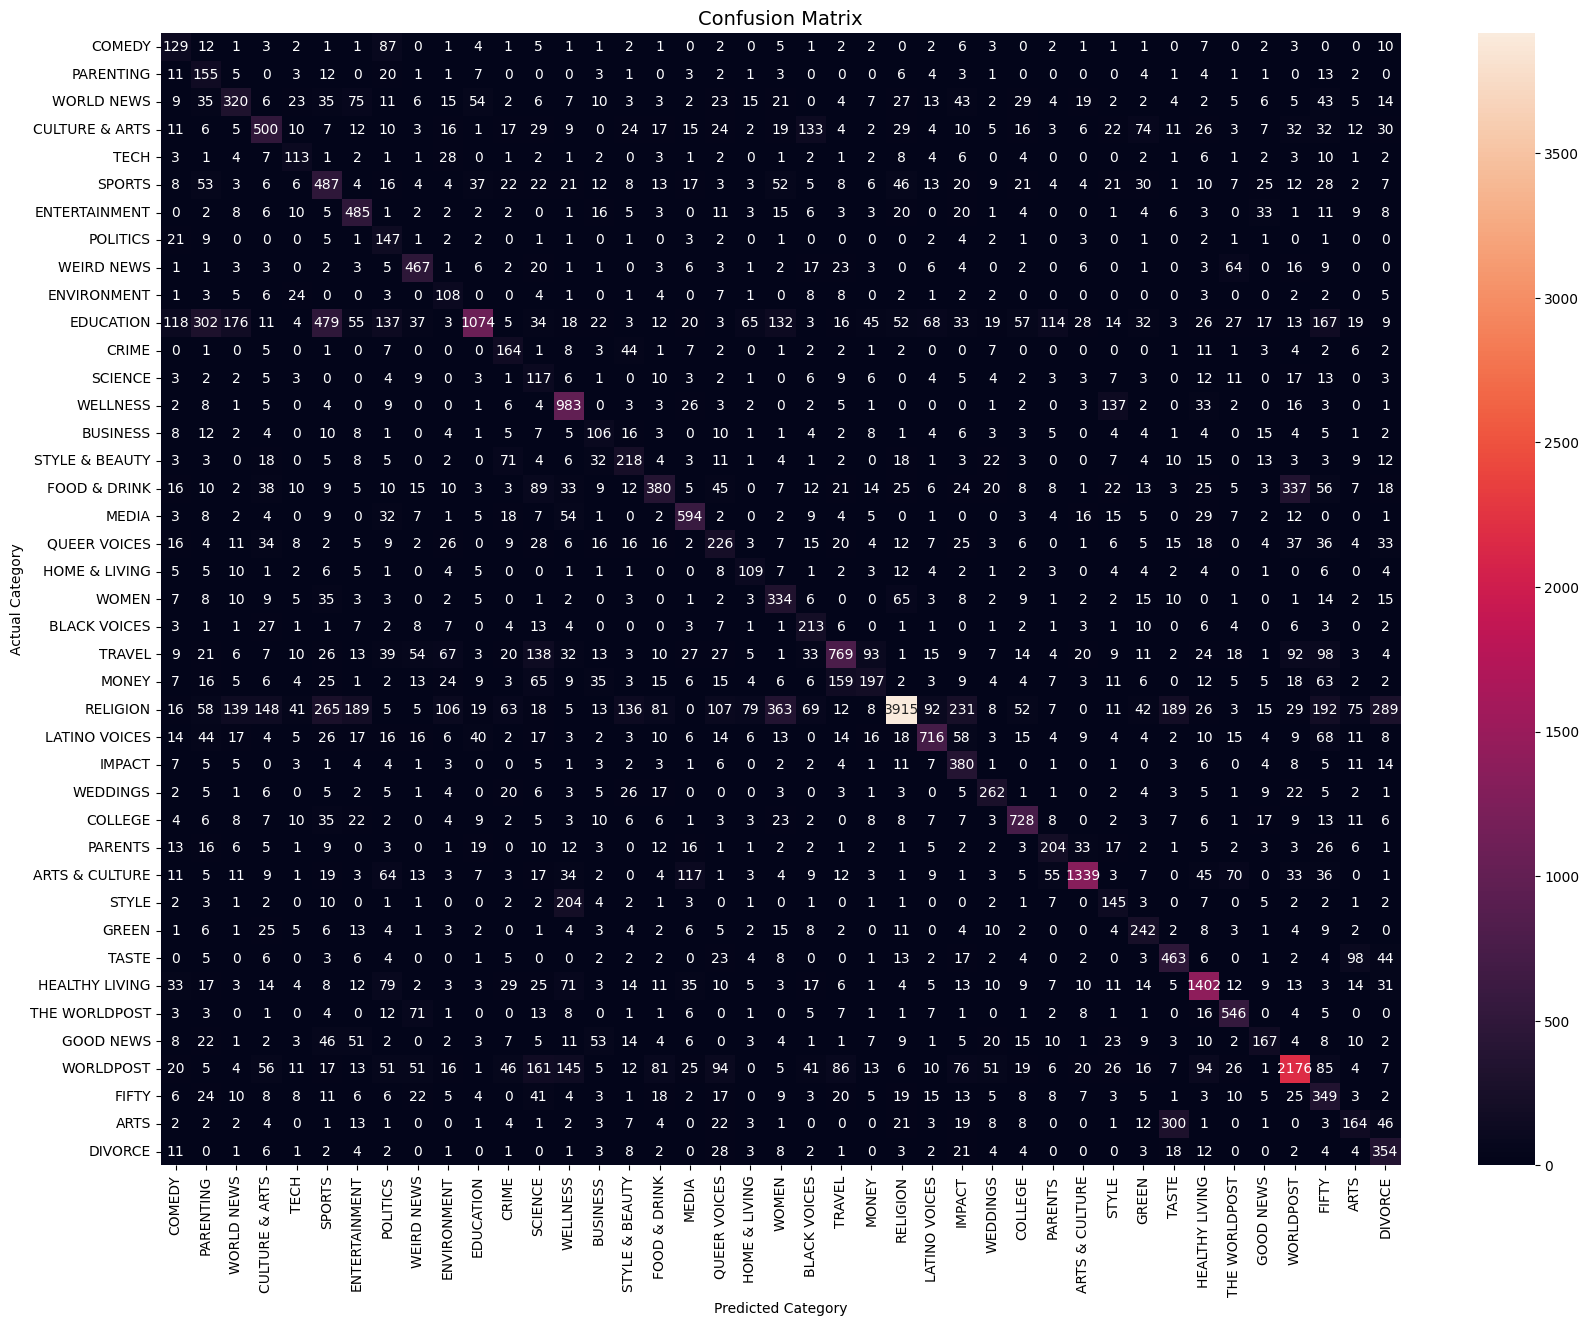

In [ ]:
# prepare confusion matrix

import seaborn as sns

plt.figure(figsize=(20,15), dpi=100)
categories = df['category'].unique()
ax = sns.heatmap(confusion_matrix(ground_truth, preds),annot=True, fmt='d')
ax.set_xlabel('Predicted Category')
ax.set_ylabel('Actual Category')
ax.xaxis.set_ticklabels(df['category'].unique())
ax.yaxis.set_ticklabels(df['category'].unique())
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.set_title('Confusion Matrix', fontsize=14)
plt.show()

In [ ]:
#define a prediction function 
def predict(text):
  token = tokenizer.encode_plus(text, return_tensors = 'pt')
  seq, mask = token['input_ids'], token['attention_mask']
  with torch.no_grad():
    model.eval()
    pred = model(seq.to(device), mask.to(device))
    pred_class = torch.argmax(pred, dim = -1)
    return df['category'][pred_class.item()]

In [ ]:
predict('Will Tory MPs rebel over small boats bill?')

'POLITICS'